In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import glob

sys.path.append('..')
import models_mae
from torchvision import transforms

/sharefs/baaihealth/xiaohongwang/.conda/envs/pt11/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 得到 CT 图像的均值和标准差

In [3]:
root_dir = '/sharefs/baaihealth/public_datasets/public_medical_images/datasets/selected4pretrain/COVID-CT/COVID-19-20_v2/data/nii2png'
# root_dir = '/sharefs/baaihealth/public_datasets/public_medical_images/datasets/selected4finetune/UCSD_AI4H_COVID_CT_data/Images-processed/U_sani2'
class_dirs = os.listdir(root_dir)
mean, std = 0, 0
count = 0

for sub_dir in class_dirs:
    # for file_path in glob.glob(os.path.join(root_dir, sub_dir, '*.png')):
    for file_path in glob.glob(os.path.join(root_dir,sub_dir)):
        img = np.array(Image.open(file_path))
        img = transforms.functional.to_tensor(img)
        mean += torch.mean(img)
        std += torch.std(img)
        count += 1

print('mean: ', mean / count)
print('std: ', std / count)

mean:  tensor(0.3320)
std:  tensor(0.3341)


### Define utils

In [4]:
imagenet_mean = np.array([0.3320])
imagenet_std = np.array([0.3341])

def show_image(image, title=''):
    # image is [H, W, 3]
    # assert image.shape[2] == 3
    plt.imshow(image)
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)
    x = x.unsqueeze(0)
    print(x.shape)
    
    # make it a batch-like
    # x = x.unsqueeze(dim=0)
    # print(x.shape)

    x = torch.einsum('nhwc->nchw', x)
    print(x.shape)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    print(y.shape)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    print(y.shape)

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
(224, 224, 3)


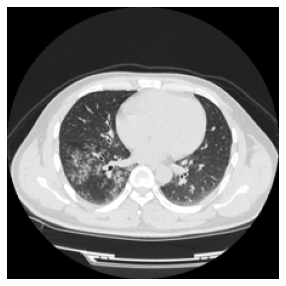

In [6]:
img = Image.open('/sharefs/baaihealth/public_datasets/public_medical_images/datasets/selected4pretrain/COVID-CT/COVID-19-20_v2/data/nii2png/volume-covid19-A-0003_116.png').convert('RGB')
# img = Image.open('/sharefs/baaihealth/public_datasets/public_medical_images/datasets/selected4finetune/UCSD_AI4H_COVID_CT_data/Images-processed/U_sani2/COVID/kjr-21-e25-p1-10.png').convert('RGB')
print(np.array(img).shape)
# print(np.array(img))
img = img.resize((224, 224))
img = np.array(img)[:, :, :] / 255

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

print(img.shape)
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [ ]:
# img = Image.open('/sharefs/baaihealth/public_datasets/public_medical_images/datasets/selected4finetune/UCSD_AI4H_COVID_CT_data/Images-processed/U_sani2/COVID/kjr-21-e25-p1-10.png').convert('RGB')
# img = np.array(img) / 255
# print(img[:, :, 0])

In [ ]:
# print(img[:, :, 1])

In [ ]:
# print(img[:, :, 2])

### Load a pre-trained MAE model

In [8]:
chkpt_dir = '/sharefs/baaihealth/xiaohongwang/medical_pretrained_models/MAE/C_orig_MAE_checkpoint_799.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:
torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
torch.Size([1, 224, 224, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


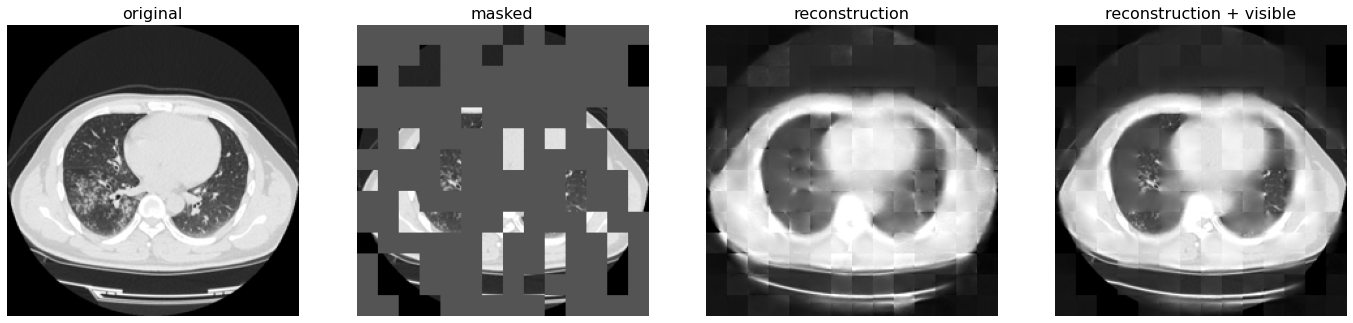

In [9]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

In [ ]:
chkpt_dir = '/sharefs/baaihealth/xiaohongwang/medical_pretrained_models/MAE/mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)